In [140]:
import csv
import re
import scipy
from scipy import stats

import requests
from io import StringIO
import csv

# Graph of sales by product

In [141]:
def getData(data_name: str):
    response = requests.get(f"http://127.0.0.1:8000/{data_name}")

    # Check if the request was successful (status code 200)
    if response.status_code == 200:

        # Create a CSV writer
        output_csv = StringIO()
        csv_writer = csv.writer(output_csv)

        # Split input string into lines and write them to the CSV
        for line in response.text.split('\\n'):
            csv_writer.writerow(line.split(','))

        # Get the CSV content as a string
        csv_content = output_csv.getvalue().replace('\\"' , '').replace('","', '#').replace('"', '')

        # Close the StringIO object
        output_csv.close()

        df = pd.read_csv(StringIO(csv_content))

        return df
    else:
        return pd.DataFrame()

product_id,product_group,product_category,product_type,product,product_description,unit_of_measure,current_wholesale_price,current_retail_price,tax_exempt_yn,promo_yn,new_product_yn
1,Whole Bean/Teas,Coffee beans,Organic Beans,Brazilian - Organic,It's like Carnival in a cup. Clean and smooth.,12 oz,14.4,$18.00 ,Y,N,N
2,Whole Bean/Teas,Coffee beans,House blend Beans,Our Old Time Diner Blend,Out packed blend of beans that is reminiscent of the cup of coffee you used to get at a diner. ,12 oz,14.4,$18.00 ,Y,N,N
3,Whole Bean/Teas,Coffee beans,Espresso Beans,Espresso Roast,Our house blend for a good espresso shot.,1 lb,11.8,$14.75 ,Y,N,N
4,Whole Bean/Teas,Coffee beans,Espresso Beans,Primo Espresso Roast,Our primium single source of hand roasted beans.,1 lb,16.36,$20.45 ,Y,N,N
5,Whole Bean/Teas,Coffee beans,Gourmet Beans,Columbian Medium Roast,A smooth cup of coffee any time of day. ,1 lb,12.0,$15.00 ,Y,N,N
6,Whole Bean/Teas,Coffee beans,Gourmet Beans,Ethiopia,From the home of coffee.,1 lb,1

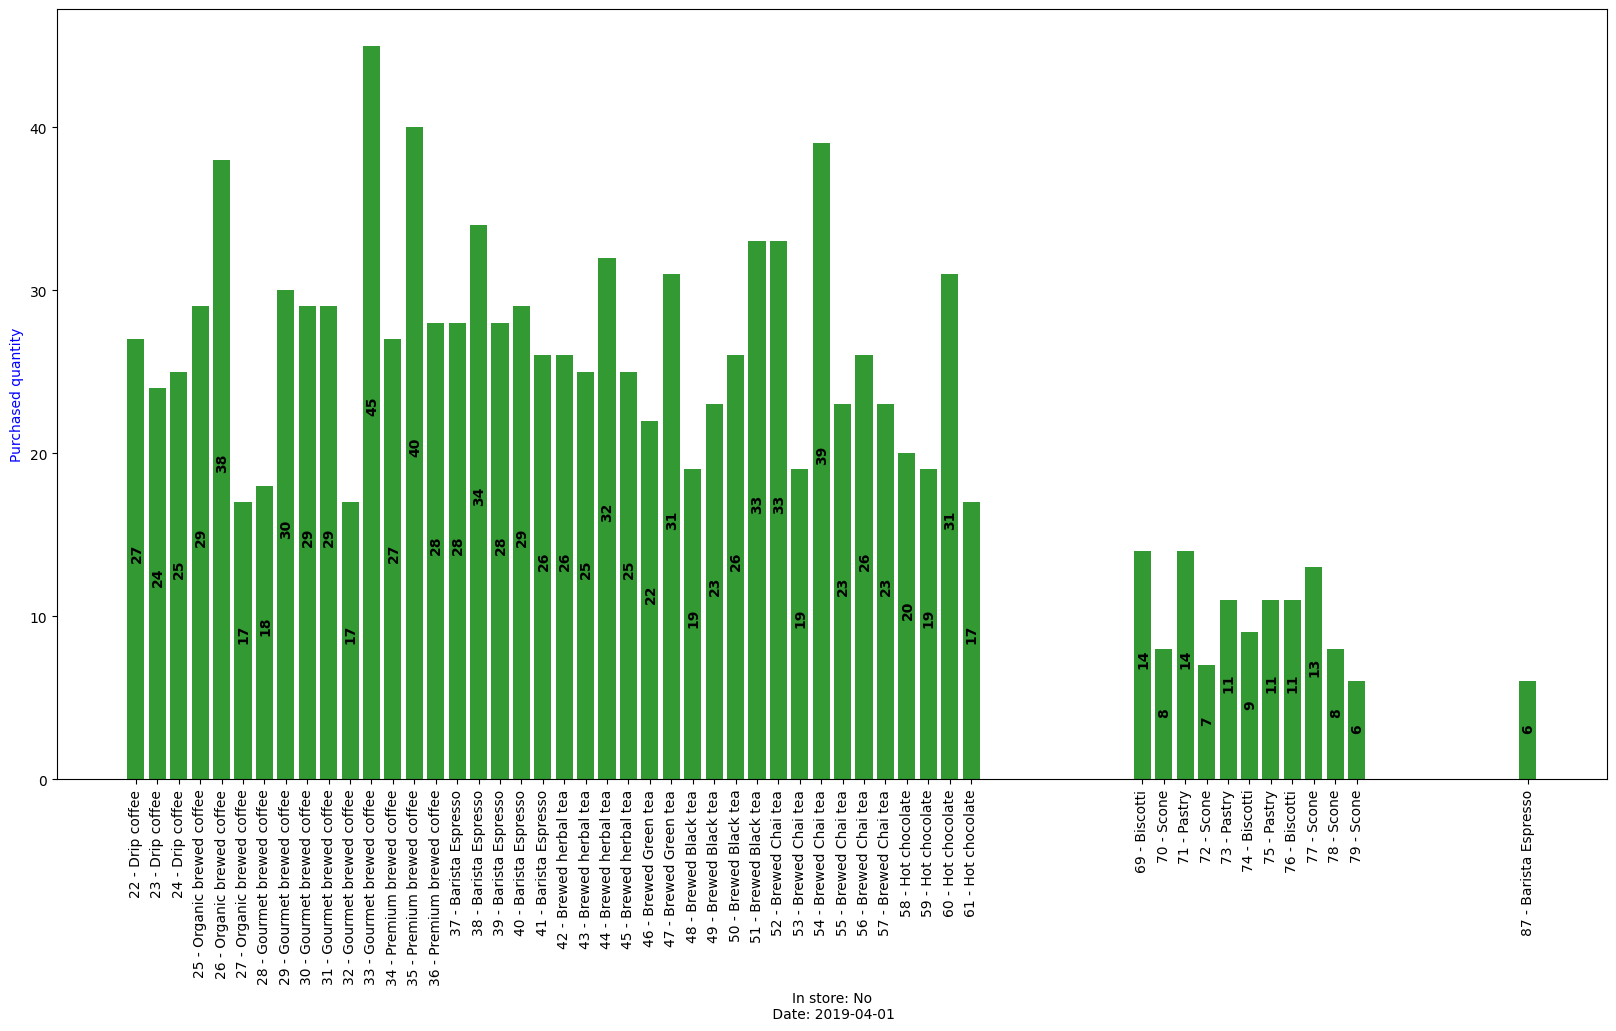

In [139]:
# products = pd.read_csv("../app/data/product.csv", delimiter=",")
products = getData('product')
products = products[['product_id', 'product_group', 'product_category', 'product_type', 'product']]

# customers = pd.read_csv("../app/data/customer.csv", delimiter=",")
customers = getData('customers')
customers = customers[['customer_id', 'gender', 'birth_year']]

# sales_receipts = pd.read_csv("../app/data/sales_reciepts.csv", delimiter=",")
sales_receipts = getData('sales_reciepts')

specific_date = '2019-04-01' # Filtering for Date
specific_instore = 'N' # Filtering for Instore

sales_receipts_final = sales_receipts.loc[
    (sales_receipts['transaction_date'].str.contains(specific_date)) &
    (sales_receipts['instore_yn'] == specific_instore)
]

filtered_sales = sales_receipts_final[['product_id', 'transaction_date', 'customer_id', 'quantity']]
sales_receipts_grouped = filtered_sales.groupby('product_id')['quantity'].sum().reset_index()
sales_receipts_final = pd.merge(sales_receipts_grouped, products, on='product_id', how='left')
sales_receipts_final.sort_values(by="product_id", ascending=False)

highest_product_id = sales_receipts_final['product_id'].max()
lowest_product_id = sales_receipts_final['product_id'].min()

bar_x_labels = []; # Labels for X axis
for id, product in zip(sales_receipts_final['product_id'], sales_receipts_final['product_type']):
    bar_x_labels.append(f"{id} - {product}")

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(sales_receipts_final['product_id'], sales_receipts_final['quantity'], color=(0.2, 0.6, 0.2, 1))
plt.xticks(sales_receipts_final['product_id'], bar_x_labels, rotation=90)

ax.set_xlabel(f"In store: {'No' if specific_instore == 'N' else 'Yes'}\n Date: {specific_date}")
ax.set_ylabel("Purchased quantity", color='blue')

for id, quan in zip(sales_receipts_final['product_id'], sales_receipts_final['quantity']):
    ax.text(id - .30, quan / 2, str(quan), color='black', fontweight='bold', rotation=90)